In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [2]:
dataset_orig = pd.read_csv('../../../data/adult.data.csv')

## Drop categorical features
dataset_orig = dataset_orig.drop(['fnlwgt','education'],axis=1)

## Drop NULL values
dataset_orig = dataset_orig.dropna()

## Change symbolics to numerics
dataset_orig['sex'] = np.where(dataset_orig['sex'] == ' Male', 1, 0)
dataset_orig['race'] = np.where(dataset_orig['race'] != ' White', 0, 1)
dataset_orig['Probability'] = np.where(dataset_orig['Probability'] == ' <=50K', 0, 1)

non_numeric_columns = list(dataset_orig.select_dtypes(exclude=[np.number]).columns)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for col in non_numeric_columns:
    dataset_orig[col] = le.fit_transform(dataset_orig[col])

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
dataset_orig = pd.DataFrame(scaler.fit_transform(dataset_orig),columns = dataset_orig.columns)

dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2, shuffle = True)

(dataset_orig.head(5))

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,Probability
0,0.301370,0.875,0.800000,0.666667,0.071429,0.2,1.0,1.0,0.02174,0.0,0.397959,0.951220,0.0
1,0.452055,0.750,0.800000,0.333333,0.285714,0.0,1.0,1.0,0.00000,0.0,0.122449,0.951220,0.0
2,0.287671,0.500,0.533333,0.000000,0.428571,0.2,1.0,1.0,0.00000,0.0,0.397959,0.951220,0.0
3,0.493151,0.500,0.400000,0.333333,0.428571,0.0,0.0,1.0,0.00000,0.0,0.397959,0.951220,0.0
4,0.150685,0.500,0.800000,0.333333,0.714286,1.0,0.0,0.0,0.00000,0.0,0.397959,0.121951,0.0


# Transforming data by LFR

In [12]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

protected_attribute = "sex"
dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2, shuffle = True, random_state=0)
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]

TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
#          k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1)

dataset_orig_train = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

TR.fit(dataset_orig_train, maxiter=500, maxfun=500)

dataset_transf = TR.transform(dataset_orig_train)
dataset_orig_train, yy = dataset_transf.convert_to_dataframe()

from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

# print("recall :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'recall'))
# print("precision :", measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'precision'))
# print("accuracy :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'accuracy'))
# print("F1 Score :",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'F1'))
print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

step: 0, loss: 1.5082039388946644, L_x: 0.3826233720469112,  L_y: 0.5791654438281147,  L_z: 0.018504245226921612
step: 250, loss: 1.083199352147647, L_x: 0.39183174232125184,  L_y: 0.5707141409227334,  L_z: 0.01017133787603402
step: 500, loss: 0.6716320881238625, L_x: 0.3902525989885566,  L_y: 0.5713586482987716,  L_z: 0.001927418276704107


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

# Graph

In [46]:
causal_graph = """
digraph {
marital_status;
workclass;
occupation;
relationship;
race;
sex;
education_num;
Probability;
U[label="Unobserved Confounders"];

sex -> Probability;
race -> Probability;
sex -> marital_status; marital_status -> Probability; 
workclass -> occupation;
marital_status -> occupation; occupation -> Probability;
race -> occupation; race -> Probability;
race -> education_num; education_num -> workclass;
workclass -> Probability;
marital_status -> relationship; relationship -> Probability
race -> occupation; race -> Probability;
race -> education_num; education_num -> workclass;
workclass -> Probability;
U->sex;U->race;U->Probability;
}
"""

## dowhy works for binary inputs only

dataset_orig_train['Probability'] = np.where(dataset_orig_train['Probability'] == 0, False, True)
dataset_orig_train[protected_attribute] = np.where(dataset_orig_train[protected_attribute] == 1, True, False)

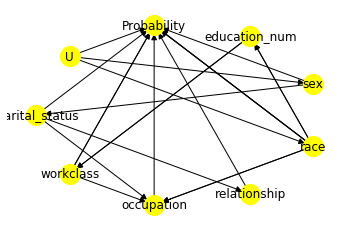

In [47]:
# With graph
model=CausalModel(
        data = dataset_orig_train,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [48]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                             
───────(Expectation(Probability|sex,relationship,marital_status))
d[race]                                                          
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,sex,relationship,marital_status,U) = P(Probability|race,sex,relationship,marital_status)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [49]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                             
───────(Expectation(Probability|sex,relationship,marital_status))
d[race]                                                          
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,sex,relationship,marital_status,U) = P(Probability|race,sex,relationship,marital_status)

## Realized estimand
b: Probability~race+sex+relationship+marital_status
Target units: ate

## Estimate
Mean value: 0.0008007411725424301

Causal Estimate is 0.0008007411725424301


In [21]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                             
───────(Expectation(Probability|sex,marital_status,relationship))
d[race]                                                          
Estimand assumption 1, Unconfoundedness: If U→{race} and U→Probability then P(Probability|race,sex,marital_status,relationship,U) = P(Probability|race,sex,marital_status,relationship)

## Realized estimand
b: Probability~race+sex+marital_status+relationship
Target units: atc

## Estimate
Mean value: -0.00014124293785310735

Causal Estimate is -0.00014124293785310735


# Add Random Common Cause

In [10]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:-0.0007826475407167941
New effect:-0.0007845538600831178



# Replace Treatment with Placebo

In [11]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:-0.0007826475407167941
New effect:2.159912899044056e-06
p value:0.41



# Remove Random Subset of Data

In [12]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:-0.0007826475407167941
New effect:-0.0008165744118864052
p value:0.4

